In [1]:
import wave
import pickle
import numpy as np
from sklearn.mixture import GaussianMixture
import librosa
import numpy as np
import pandas as pd
import os

In [2]:
!pip install auditok

In [3]:
from auditok import DataValidator, ADSFactory, DataSource, StreamTokenizer, BufferAudioSource, player_for

In [4]:
def extract_mfcc(signal, sr=16000, n_mfcc=16, n_fft=256, hop_length=128, n_mels = 40, delta_1 = False, delta_2 = False):
    
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    
    if not (delta_1 or delta_2):
        return mfcc.T
    
    feat = [mfcc]
    
    if delta_1:
        mfcc_delta_1 = librosa.feature.delta(mfcc, order=1)
        feat.append(mfcc_delta_1)
    
    if delta_2:
        mfcc_delta_2 = librosa.feature.delta(mfcc, order=2)
        feat.append(mfcc_delta_2)
        
    return np.vstack(feat).T


def file_to_mfcc(filename, sr=16000, **kwargs):
    
    signal, sr = librosa.load(filename, sr = sr)
    
    return extract_mfcc(signal, sr, **kwargs)

In [5]:
class GMMClassifier():
    
    def __init__(self, models):
        """
        models is a dictionary: {"class_of_sound" : GMM_model_for_that_class, ...}
        """        
        self.models = models
    
    def predict(self, data):
        
        result = []
        for cls in self.models:
            
            llk = self.models[cls].score_samples(data)[0]
            llk = np.sum(llk)
            result.append((cls, llk)) 
        
        """
        return classification result as a sorted list of tuples ("class_of_sound", log_likelihood)
        best class is the first element in the list
        """
        return sorted(result, key=lambda f: - f[1])

In [6]:
class ClassifierValidator(DataValidator):
    
    def __init__(self, classifier, target):
        """
        classifier: a GMMClassifier object
        target: string
        """
        self.classifier = classifier
        self.target = target
        
    def is_valid(self, data):
        
        r = self.classifier.predict(data)
        return r[0][0] == self.target

In [7]:
class VectorDataSource(DataSource):
     
    def __init__(self, data, scope=0):
        self.scope = scope
        self._data = data
        self._current = 0
    
    def read(self):
        if self._current >= len(self._data):
            return None
        
        start = self._current - self.scope
        if start < 0:
            start = 0
            
        end = self._current + self.scope + 1
        
        self._current += 1
        return self._data[start : end]
    
    def set_scope(self, scope):
        self.scope = scope
            
    def rewind(self):
        self._current = 0

In [8]:
"""
Size of audio window for which MFCC coefficients are calculated
"""
ANALYSIS_WINDOW = 0.02 # 0.02 second = 20 ms

"""
Step of ANALYSIS_WINDOW 
"""
ANALYSIS_STEP = 0.01 # 0.01 second overlap between consecutive windows

"""
number of vectors around the current vector to return.
This will cause VectorDataSource.read() method to return
a sequence of (SCOPE_LENGTH * 2 + 1) vectors (if enough
data is available), with the current vetor in the middle
"""
SCOPE_LENGTH = 10

"""
Number of Mel filters
"""
MEL_FILTERS = 40

"""
Number of MFCC coefficients to keep
"""
N_MFCC = 16

"""
Sampling rate of audio data
"""
SAMPLING_RATE = 16000

"""
ANALYSIS_WINDOW and ANALYSIS_STEP as number of samples
"""
BLOCK_SIZE = int(SAMPLING_RATE * ANALYSIS_WINDOW)
HOP_SIZE = int(SAMPLING_RATE * ANALYSIS_STEP)

"""
Compute delta and delta-delta of MFCC coefficients ?
"""
DELTA_1 = True
DELTA_2 = True

"""
Where to find data
"""
PREFIX = "data/train"


In [9]:
import tensorflow as tf
from tensorflow import keras

In [10]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving silence_1.wav to silence_1.wav
Saving silence_2.wav to silence_2.wav
Saving voice-data.wav to voice-data.wav
Saving voice-data-silence.wav to voice-data-silence.wav
Saving voicesample.wav to voicesample.wav
Saving voicesample1.wav to voicesample1.wav
Saving voicesample2.wav to voicesample2.wav
Saving voicesample9.wav to voicesample9.wav
Saving voicesample10.wav to voicesample10.wav
Saving voicesample11.wav to voicesample11.wav
User uploaded file "silence_1.wav" with length 81358 bytes
User uploaded file "silence_2.wav" with length 81358 bytes
User uploaded file "voice-data.wav" with length 12042318 bytes
User uploaded file "voice-data-silence.wav" with length 81358 bytes
User uploaded file "voicesample.wav" with length 369358 bytes
User uploaded file "voicesample1.wav" with length 91598 bytes
User uploaded file "voicesample2.wav" with length 183118 bytes
User uploaded file "voicesample9.wav" with length 362318 bytes
User uploaded file "voicesample10.wav" with length 180558 bytes

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
train_data = {}

train_data["silence"] = ["silence_1.wav", "silence_2.wav", "voice-data-silence.wav"]
train_data["voicesample"]  = ["voicesample.wav", "voicesample1.wav", "voicesample2.wav", "voicesample9.wav", "voicesample10.wav", "voicesample11.wav"]

models = {}

# build models
for cls in train_data:

    data = []
    for fname in train_data[cls]:
        data.append(file_to_mfcc( fname, sr=16000, n_mfcc=N_MFCC, n_fft=BLOCK_SIZE, hop_length=HOP_SIZE, n_mels=MEL_FILTERS, delta_1=DELTA_1, delta_2=DELTA_2))

    data = np.vstack(data)
    
    print("Class '{0}': {1} training vectors".format(cls, data.shape[0]))

    mod = GaussianMixture(n_components=10)
    mod.fit(data)
    models[cls] = mod

gmm_classifier = GMMClassifier(models)

# create a validator for each sound class
silence_validator = ClassifierValidator(gmm_classifier, "silence")
voicesample_validator = ClassifierValidator(gmm_classifier, "voicesample")

Class 'silence': 384 training vectors
Class 'voicesample': 2472 training vectors


In [14]:
# transform audio stream to be analyzed into a sequence of MFCC vectors
# create a DataSource object using MFCC vectors
mfcc_data_source = VectorDataSource(data=file_to_mfcc("voice-data.wav",
                                                      sr=16000, n_mfcc=N_MFCC,
                                                      n_fft=BLOCK_SIZE, hop_length=HOP_SIZE,
                                                      n_mels=MEL_FILTERS, delta_1=DELTA_1,
                                                      delta_2=DELTA_2), scope=SCOPE_LENGTH)

In [16]:
# create a tokenizer
analysis_window_per_second = 1. / ANALYSIS_STEP

min_seg_length = 0.5 # second, min length of an accepted audio segment
max_seg_length = 10 # seconds, max length of an accepted audio segment
max_silence = 0.3 # second, max length tolerated of tolerated continuous signal that's not from the same class

tokenizer = StreamTokenizer(validator=silence_validator, min_length=int(min_seg_length * analysis_window_per_second),
                                max_length=int(max_seg_length * analysis_window_per_second),
                                max_continuous_silence= max_silence * analysis_window_per_second,
                                mode = StreamTokenizer.DROP_TRAILING_SILENCE)

In [18]:
# read all audio data from stream
wfp = wave.open("voice-data.wav")
audio_data = wfp.readframes(-1)
width = wfp.getsampwidth()
wfp.close()

# data as numpy array will be used to plot signal
fmt = {1: np.int8 , 2: np.int16, 4: np.int32}
signal = np.array(np.frombuffer(audio_data, dtype=fmt[width]), dtype=np.float64)

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 24, 18

def plot_signal_and_segmentation(signal, sampling_rate, segments=[]):
    _time = np.arange(0., np.ceil(float(len(signal))) / sampling_rate, 1./sampling_rate )
    if len(_time) > len(signal):
        _time = _time[: len(signal) - len(_time)]
    
    pylab.subplot(211)

    for seg in segments:
        
        fc = seg.get("fc", "g")
        ec = seg.get("ec", "b")
        lw = seg.get("lw", 2)
        alpha = seg.get("alpha", 0.4)
        
        ts = seg["timestamps"]
        
        # plot first segmentation outside loop to show one single legend for this class
        p = pylab.axvspan(ts[0][0], ts[0][1], fc=fc, ec=ec, lw=lw, alpha=alpha, label = seg.get("title", ""))
        
        for start, end in ts[1:]:
            p = pylab.axvspan(start, end, fc=fc, ec=ec, lw=lw, alpha=alpha)
            
            
    pylab.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
            borderaxespad=0., fontsize=22, ncol=2)
    
    pylab.plot(_time, signal)
    
    pylab.xlabel("Time (s)", fontsize=22)
    pylab.ylabel("Signal Amplitude", fontsize=22)
    pylab.show()

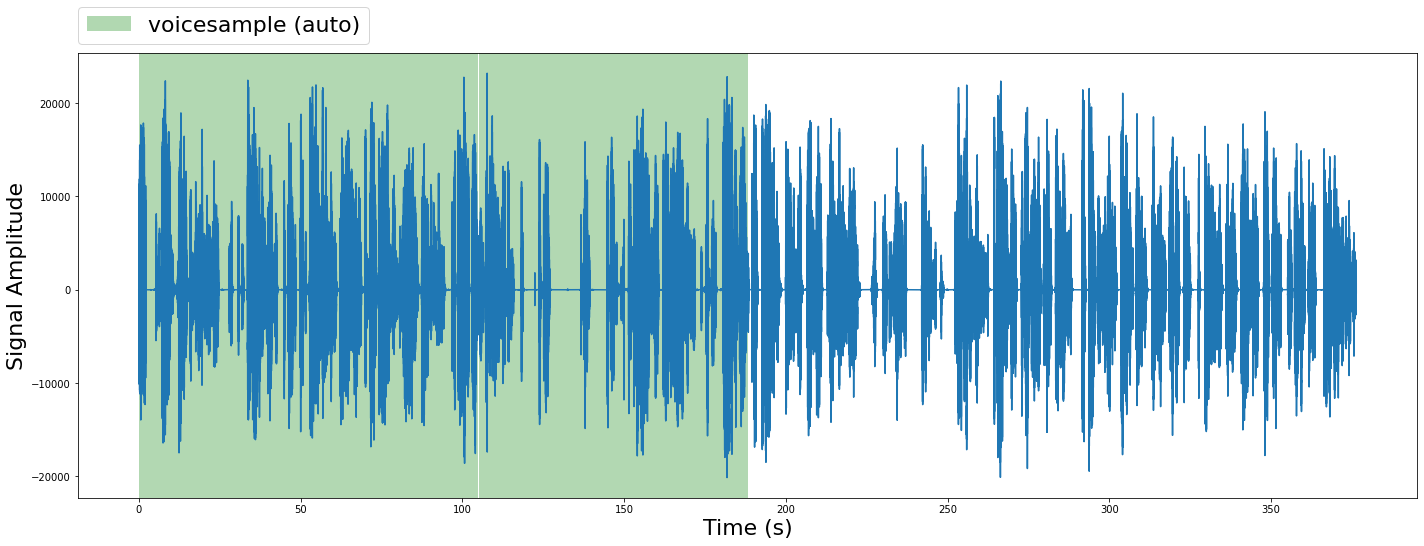

In [21]:
tokenizer = StreamTokenizer(validator=voicesample_validator, min_length= int(0.5 * analysis_window_per_second),
                                max_length=int(15 * analysis_window_per_second),
                                max_continuous_silence= 0.3 * analysis_window_per_second,
                                mode = StreamTokenizer.DROP_TRAILING_SILENCE)
tokenizer.validator = voicesample_validator
mfcc_data_source.rewind()
mfcc_data_source.scope = 0
tokens = tokenizer.tokenize(mfcc_data_source)
ts = [(t[1] * ANALYSIS_STEP, t[2] * ANALYSIS_STEP) for t in tokens]

seg = {"fc" : "g", "ec" : "g", "lw" : 0, "alpha" : 0.3, "title" : "voicesample (auto)", "timestamps" : ts}

plot_signal_and_segmentation(signal, SAMPLING_RATE, [seg])

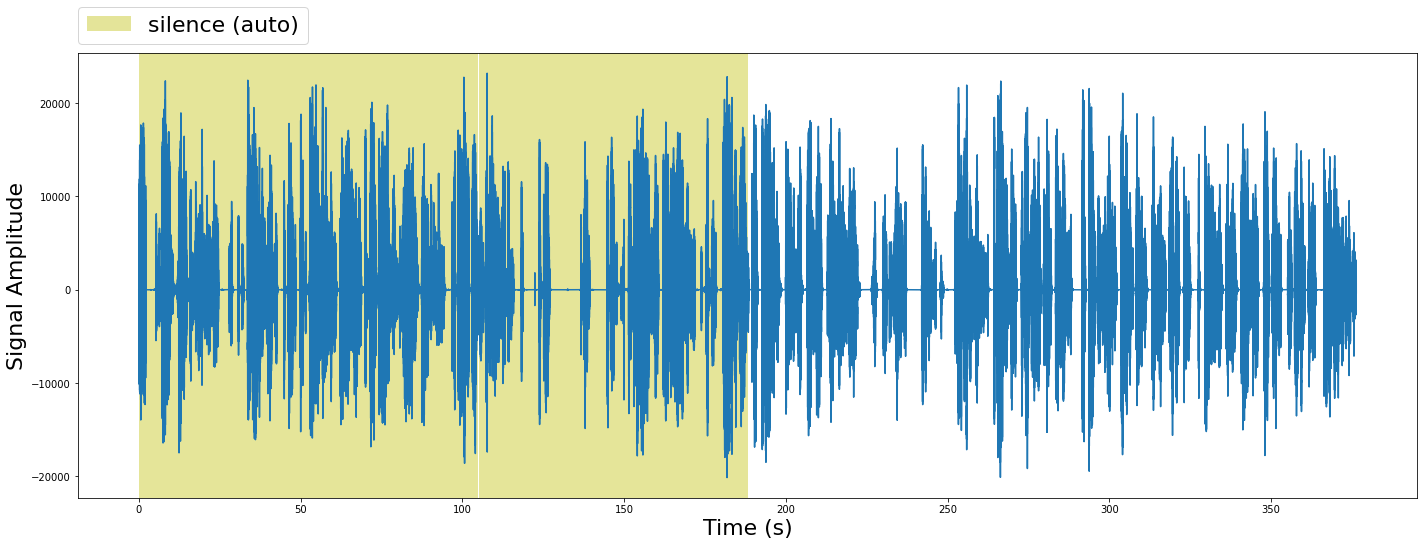

In [24]:
tokenizer.validator = silence_validator
mfcc_data_source.rewind()
mfcc_data_source.scope = 0
tokens = tokenizer.tokenize(mfcc_data_source)
ts = [(t[1] * ANALYSIS_STEP, t[2] * ANALYSIS_STEP) for t in tokens]
seg = {"fc" : "y", "ec" : "y", "lw" : 0, "alpha" : 0.4, "title" : "silence (auto)", "timestamps" : ts}
plot_signal_and_segmentation(signal, SAMPLING_RATE, [seg])